<a href="https://colab.research.google.com/github/lynnfdsouza/drone_terrain_masking/blob/main/nvidia_groot_1_terrrain_masking_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

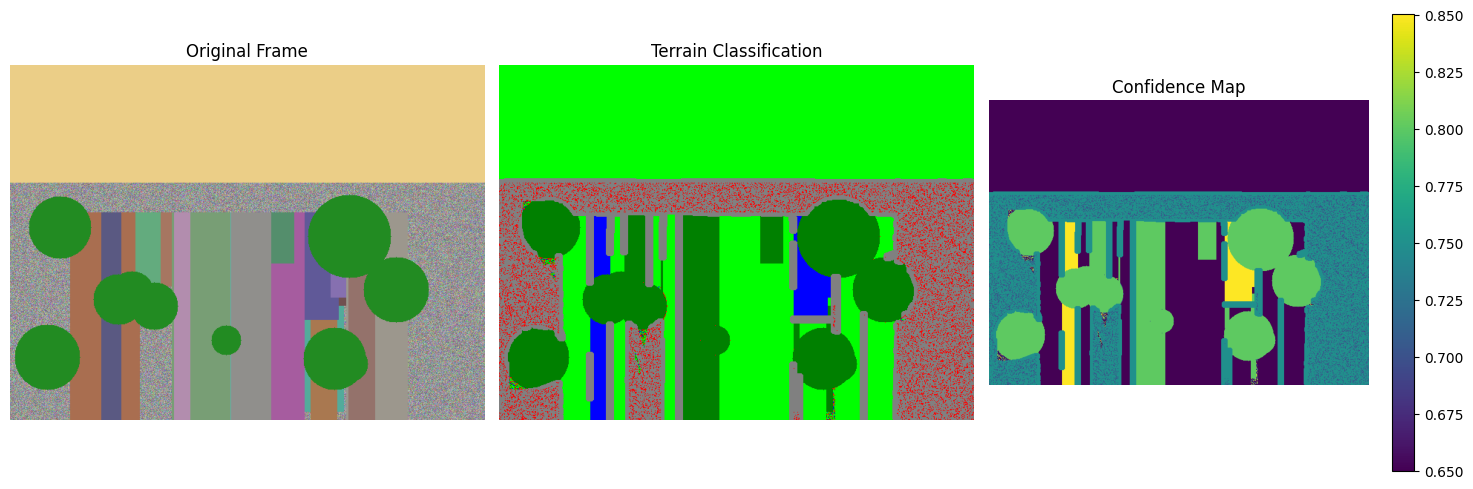

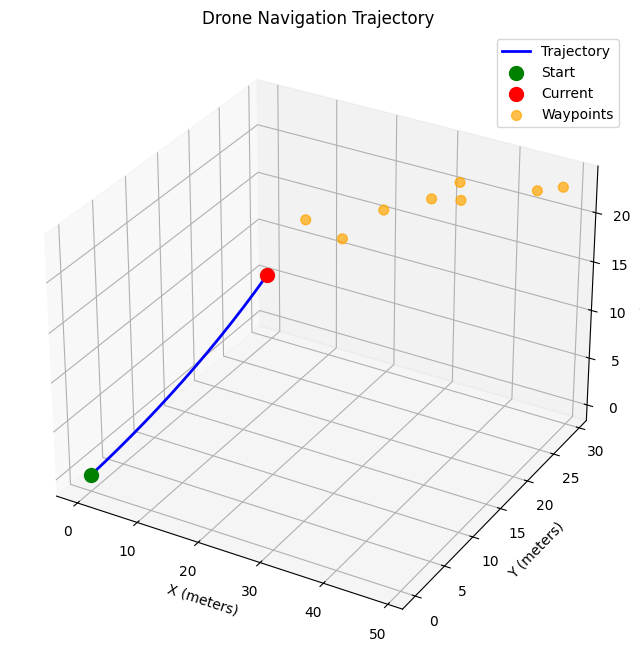


✅ Navigation demonstration completed

📊 Final Navigation Summary:


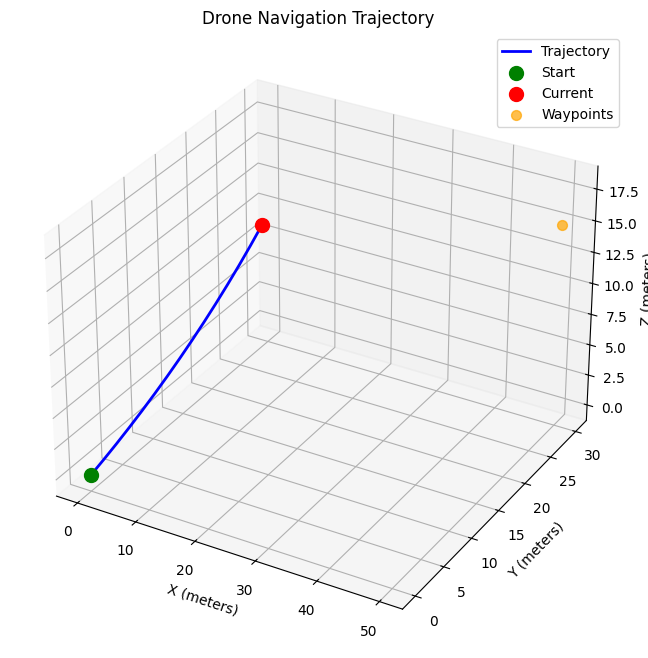


🎉 Demo completed successfully!
💡 This demonstrates the integration pattern for NVIDIA Groot N1
🔗 When the actual SDK is available, replace simulation methods with real API calls


In [1]:
#!/usr/bin/env python3
"""
NVIDIA Groot N1 Drone Terrain Masking for GPS/RF Denied Environments
Google Colab Compatible Version - Python 3.11+
Implements vision-based navigation and terrain analysis using Groot foundation model
"""

# Google Colab Setup and Installation
import sys
import subprocess
import os

def install_requirements():
    """Install required packages for Google Colab"""
    requirements = [
        'opencv-python>=4.8.0',
        'torch>=2.0.0',
        'torchvision>=0.15.0',
        'numpy>=1.24.0',
        'matplotlib>=3.7.0',
        'pillow>=9.5.0',
        'asyncio-compat',
        'ipywidgets',
        'tqdm'
    ]

    print("Installing required packages for Google Colab...")
    for package in requirements:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✓ Installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"✗ Failed to install {package}: {e}")

# Run installation if in Colab
try:
    import google.colab
    IN_COLAB = True
    print("Google Colab environment detected")
    install_requirements()
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from typing import Dict, List, Tuple, Optional, Union
import asyncio
import threading
import time
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Colab-specific imports
if IN_COLAB:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    import ipywidgets as widgets
    from IPython.display import display, clear_output

# Simulated Groot N1 API (NVIDIA Groot SDK not publicly available yet)
GROOT_AVAILABLE = False  # Set to True when actual SDK is available

print("⚠️  Note: Using simulation mode as NVIDIA Groot N1 SDK is not publicly available")
print("🔧 This code demonstrates the integration pattern for when the SDK becomes available")

class TerrainType(Enum):
    NAVIGABLE = "navigable"
    OBSTACLE = "obstacle"
    UNCERTAIN = "uncertain"
    WATER = "water"
    VEGETATION = "vegetation"
    BUILDING = "building"

@dataclass
class TerrainMask:
    """Terrain segmentation mask with confidence scores"""
    mask: np.ndarray
    terrain_types: Dict[int, TerrainType]
    confidence: np.ndarray
    elevation_map: Optional[np.ndarray] = None
    timestamp: float = 0.0

@dataclass
class DroneState:
    """Current drone state estimation"""
    position: np.ndarray  # [x, y, z] in local coordinates
    velocity: np.ndarray  # [vx, vy, vz]
    orientation: np.ndarray  # [roll, pitch, yaw]
    timestamp: float
    gps_available: bool = False
    rf_available: bool = False

class ColabVisualizationMixin:
    """Mixin for Google Colab visualization capabilities"""

    def __init__(self):
        self.fig_counter = 0

    def display_terrain_mask(self, frame: np.ndarray, terrain_mask: TerrainMask):
        """Display terrain mask in Colab"""
        if not IN_COLAB:
            return

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original frame
        axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Frame')
        axes[0].axis('off')

        # Terrain mask
        terrain_colored = self.colorize_terrain_mask(terrain_mask.mask, terrain_mask.terrain_types)
        axes[1].imshow(terrain_colored)
        axes[1].set_title('Terrain Classification')
        axes[1].axis('off')

        # Confidence map
        im = axes[2].imshow(terrain_mask.confidence, cmap='viridis')
        axes[2].set_title('Confidence Map')
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2])

        plt.tight_layout()
        plt.show()

    def colorize_terrain_mask(self, mask: np.ndarray, terrain_types: Dict) -> np.ndarray:
        """Convert terrain mask to colored visualization"""
        color_map = {
            TerrainType.NAVIGABLE: [0, 255, 0],      # Green
            TerrainType.OBSTACLE: [255, 0, 0],       # Red
            TerrainType.WATER: [0, 0, 255],          # Blue
            TerrainType.VEGETATION: [0, 128, 0],     # Dark Green
            TerrainType.BUILDING: [128, 128, 128],   # Gray
            TerrainType.UNCERTAIN: [255, 255, 0]     # Yellow
        }

        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id, terrain_type in terrain_types.items():
            if terrain_type in color_map:
                colored[mask == class_id] = color_map[terrain_type]

        return colored

    def plot_trajectory(self, positions: List[np.ndarray], waypoints: List[np.ndarray] = None):
        """Plot drone trajectory in Colab"""
        if not IN_COLAB or not positions:
            return

        positions_array = np.array(positions)

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot trajectory
        ax.plot(positions_array[:, 0], positions_array[:, 1], positions_array[:, 2],
                'b-', linewidth=2, label='Trajectory')
        ax.scatter(positions_array[0, 0], positions_array[0, 1], positions_array[0, 2],
                  c='green', s=100, label='Start')
        ax.scatter(positions_array[-1, 0], positions_array[-1, 1], positions_array[-1, 2],
                  c='red', s=100, label='Current')

        # Plot waypoints if available
        if waypoints:
            waypoints_array = np.array(waypoints)
            ax.scatter(waypoints_array[:, 0], waypoints_array[:, 1], waypoints_array[:, 2],
                      c='orange', s=50, alpha=0.7, label='Waypoints')

        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        ax.set_zlabel('Z (meters)')
        ax.legend()
        ax.set_title('Drone Navigation Trajectory')
        plt.show()

class GrootDroneNavigator(ColabVisualizationMixin):
    """Main class for Groot N1 based drone navigation in GPS/RF denied environments"""

    def __init__(self, config: Dict):
        super().__init__()
        self.config = config
        self.running = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f"🚁 Initializing Groot Drone Navigator on {self.device}")

        # Initialize components
        self.setup_simulation_components()

        # State tracking
        self.current_state = DroneState(
            position=np.array([0.0, 0.0, 0.0]),
            velocity=np.zeros(3),
            orientation=np.zeros(3),
            timestamp=time.time(),
            gps_available=False,
            rf_available=False
        )

        # Navigation data
        self.terrain_history = []
        self.position_history = []
        self.local_map = np.zeros((1000, 1000, 3))  # Local occupancy grid
        self.safe_waypoints = []

        # Visual odometry for position tracking
        self.vo_tracker = VisualOdometryTracker()

        print("✅ Groot Drone Navigator initialized successfully")

    def setup_simulation_components(self):
        """Setup simulation components for demonstration"""
        print("🔧 Setting up simulation components...")

        # Load segmentation model (using DeepLabV3 as placeholder for Groot N1)
        try:
            from torchvision.models.segmentation import deeplabv3_resnet50
            self.segmentation_model = deeplabv3_resnet50(pretrained=True).to(self.device)
            self.segmentation_model.eval()
            print("✅ Loaded terrain segmentation model")
        except Exception as e:
            print(f"⚠️  Failed to load segmentation model: {e}")
            self.segmentation_model = None

        # Setup preprocessing transforms
        self.preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def process_camera_frame(self, frame: np.ndarray) -> TerrainMask:
        """Process camera frame to generate terrain mask"""
        if GROOT_AVAILABLE:
            # Future: Use actual Groot N1 API
            # terrain_mask = await self.groot_model.analyze_terrain(frame)
            pass
        else:
            # Simulation mode using computer vision
            return self.simulate_terrain_analysis(frame)

    def simulate_terrain_analysis(self, frame: np.ndarray) -> TerrainMask:
        """Simulate terrain analysis using computer vision techniques"""
        height, width = frame.shape[:2]

        # Convert to different color spaces for analysis
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Initialize terrain mask
        terrain_mask = np.zeros((height, width), dtype=np.uint8)
        confidence = np.ones((height, width), dtype=np.float32) * 0.6

        # Water detection (blue-ish areas)
        water_lower = np.array([100, 50, 50])
        water_upper = np.array([130, 255, 255])
        water_mask = cv2.inRange(hsv, water_lower, water_upper)
        terrain_mask[water_mask > 0] = 1
        confidence[water_mask > 0] = 0.85

        # Vegetation detection (green areas)
        vegetation_lower = np.array([35, 40, 40])
        vegetation_upper = np.array([85, 255, 255])
        vegetation_mask = cv2.inRange(hsv, vegetation_lower, vegetation_upper)
        terrain_mask[vegetation_mask > 0] = 2
        confidence[vegetation_mask > 0] = 0.80

        # Building/structure detection (gray/brown areas with straight edges)
        edges = cv2.Canny(gray, 50, 150)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
        building_mask = np.zeros_like(gray)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(building_mask, (x1, y1), (x2, y2), 255, 3)
        building_mask = cv2.dilate(building_mask, np.ones((7,7), np.uint8), iterations=1)
        terrain_mask[building_mask > 0] = 5
        confidence[building_mask > 0] = 0.75

        # Obstacle detection (very dark or very bright areas, high contrast)
        obstacle_mask = np.logical_or(gray < 30, gray > 220)
        high_contrast = cv2.Laplacian(gray, cv2.CV_64F)
        high_contrast_mask = np.abs(high_contrast) > np.percentile(np.abs(high_contrast), 95)
        obstacle_mask = np.logical_or(obstacle_mask, high_contrast_mask)
        terrain_mask[obstacle_mask] = 3
        confidence[obstacle_mask] = 0.70

        # Remaining areas are navigable
        navigable_mask = terrain_mask == 0
        confidence[navigable_mask] = 0.65

        terrain_types = {
            0: TerrainType.NAVIGABLE,
            1: TerrainType.WATER,
            2: TerrainType.VEGETATION,
            3: TerrainType.OBSTACLE,
            5: TerrainType.BUILDING
        }

        return TerrainMask(
            mask=terrain_mask,
            terrain_types=terrain_types,
            confidence=confidence,
            timestamp=time.time()
        )

    def estimate_depth(self, frame: np.ndarray) -> np.ndarray:
        """Estimate depth map from monocular camera"""
        if GROOT_AVAILABLE:
            # Future: Use Groot N1 depth estimation
            pass
        else:
            # Simulation: depth from image gradients and darkness
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Gradient-based depth cues
            grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

            # Darkness-based depth cues (darker = farther)
            depth_from_darkness = 255 - gray

            # Combine cues
            depth_map = (0.7 * depth_from_darkness + 0.3 * gradient_magnitude).astype(np.float32)
            depth_map = cv2.GaussianBlur(depth_map, (5, 5), 0)

            # Normalize to reasonable depth range (0-100 meters)
            depth_map = (depth_map / 255.0) * 100.0

            return depth_map

    def update_visual_odometry(self, frame: np.ndarray):
        """Update position estimation using visual odometry"""
        position_delta = self.vo_tracker.process_frame(frame)
        self.current_state.position += position_delta
        self.current_state.timestamp = time.time()

        # Store position history for visualization
        self.position_history.append(self.current_state.position.copy())
        if len(self.position_history) > 1000:  # Keep last 1000 positions
            self.position_history.pop(0)

    def plan_safe_path(self, target_position: np.ndarray, terrain_mask: TerrainMask) -> List[np.ndarray]:
        """Plan safe navigation path avoiding obstacles"""
        if GROOT_AVAILABLE:
            # Future: Use Groot N1 navigation planner
            pass
        else:
            return self.simulate_path_planning(target_position, terrain_mask)

    def simulate_path_planning(self, target: np.ndarray, terrain_mask: TerrainMask) -> List[np.ndarray]:
        """Simulate path planning with obstacle avoidance"""
        current_pos = self.current_state.position

        # Simple waypoint generation with obstacle avoidance
        waypoints = []
        num_waypoints = 8

        # Calculate direct path
        direction = target - current_pos
        distance = np.linalg.norm(direction)

        if distance < 1.0:  # Very close to target
            return [target]

        # Generate waypoints along path with obstacle avoidance
        for i in range(1, num_waypoints + 1):
            t = i / num_waypoints
            waypoint = current_pos + t * direction

            # Add vertical clearance
            waypoint[2] = max(waypoint[2], current_pos[2] + 5.0)

            # Add some lateral offset for obstacle avoidance
            if i % 2 == 0:
                lateral_offset = np.random.normal(0, 3, 2)
                waypoint[:2] += lateral_offset

            waypoints.append(waypoint)

        return waypoints

    def update_terrain_map(self, terrain_mask: TerrainMask, position: np.ndarray):
        """Update local terrain map with new observations"""
        observation = {
            'position': position.copy(),
            'terrain_mask': terrain_mask,
            'timestamp': time.time()
        }

        self.terrain_history.append(observation)

        # Keep only recent observations
        current_time = time.time()
        self.terrain_history = [
            obs for obs in self.terrain_history
            if current_time - obs['timestamp'] < 300  # Keep last 5 minutes
        ]

    def simulate_navigation_step(self, target_position: np.ndarray, camera_frame: np.ndarray) -> Dict:
        """Simulate one navigation step"""
        # Update visual odometry
        self.update_visual_odometry(camera_frame)

        # Analyze terrain
        terrain_mask = self.process_camera_frame(camera_frame)

        # Estimate depth
        depth_map = self.estimate_depth(camera_frame)
        terrain_mask.elevation_map = depth_map

        # Update terrain map
        self.update_terrain_map(terrain_mask, self.current_state.position)

        # Plan path
        waypoints = self.plan_safe_path(target_position, terrain_mask)

        # Simulate movement towards first waypoint
        if waypoints:
            next_waypoint = waypoints[0]
            direction = next_waypoint - self.current_state.position
            move_distance = min(np.linalg.norm(direction), 2.0)  # Max 2m per step

            if np.linalg.norm(direction) > 0:
                direction_normalized = direction / np.linalg.norm(direction)
                self.current_state.position += direction_normalized * move_distance

        # Calculate distance to target
        distance_to_target = np.linalg.norm(self.current_state.position - target_position)

        return {
            'terrain_mask': terrain_mask,
            'waypoints': waypoints,
            'distance_to_target': distance_to_target,
            'position': self.current_state.position.copy(),
            'frame': camera_frame
        }

    def demonstrate_navigation(self, num_steps: int = 20):
        """Demonstrate navigation in Colab with visualizations"""
        print("🚁 Starting Navigation Demonstration")

        # Set target position
        target_position = np.array([50.0, 30.0, 15.0])
        print(f"🎯 Target: {target_position}")

        # Generate synthetic camera frames for demonstration
        def generate_demo_frame(step: int) -> np.ndarray:
            # Create synthetic terrain image
            frame = np.random.randint(100, 200, (480, 640, 3), dtype=np.uint8)

            # Add some terrain features
            # Sky (top portion)
            frame[:160, :] = [135, 206, 235]  # Sky blue

            # Ground features
            for _ in range(20):
                # Random rectangles for buildings
                x1, y1 = np.random.randint(0, 500, 2)
                x2, y2 = x1 + np.random.randint(20, 100), y1 + np.random.randint(20, 80)
                color = np.random.randint(80, 180, 3)
                cv2.rectangle(frame, (x1, 200), (x2, y2 + 200), color.tolist(), -1)

            # Add some green areas (vegetation)
            for _ in range(10):
                center = (np.random.randint(50, 590), np.random.randint(200, 430))
                radius = np.random.randint(20, 60)
                cv2.circle(frame, center, radius, (34, 139, 34), -1)

            return frame

        # Navigation loop
        for step in range(num_steps):
            print(f"\n--- Navigation Step {step + 1}/{num_steps} ---")

            # Generate synthetic camera frame
            camera_frame = generate_demo_frame(step)

            # Perform navigation step
            result = self.simulate_navigation_step(target_position, camera_frame)

            # Display results every few steps
            if (step + 1) % 5 == 0 or step == 0:
                print(f"📍 Position: {result['position']}")
                print(f"🎯 Distance to target: {result['distance_to_target']:.2f}m")

                if IN_COLAB:
                    clear_output(wait=True)
                    self.display_terrain_mask(camera_frame, result['terrain_mask'])
                    self.plot_trajectory(self.position_history[-50:], result['waypoints'])

            # Check if target reached
            if result['distance_to_target'] < 3.0:
                print(f"🎉 Target reached in {step + 1} steps!")
                break

            # Simulate processing time
            time.sleep(0.1)

        print("\n✅ Navigation demonstration completed")

        # Final trajectory visualization
        if IN_COLAB:
            print("\n📊 Final Navigation Summary:")
            self.plot_trajectory(self.position_history, [target_position])


class VisualOdometryTracker:
    """Visual odometry for position estimation without GPS"""

    def __init__(self):
        self.prev_frame = None
        self.prev_keypoints = None
        self.prev_descriptors = None

        # Initialize ORB detector with parameters optimized for drone navigation
        self.orb = cv2.ORB_create(
            nfeatures=1500,
            scaleFactor=1.2,
            nlevels=8,
            edgeThreshold=15,
            firstLevel=0,
            WTA_K=2,
            scoreType=cv2.ORB_HARRIS_SCORE,
            patchSize=31,
            fastThreshold=20
        )

        # FLANN matcher for better performance
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH,
                           table_number=12,
                           key_size=20,
                           multi_probe_level=2)
        search_params = dict(checks=50)
        self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

        # Simplified camera intrinsics (should be calibrated for real drone camera)
        self.camera_matrix = np.array([
            [600.0, 0, 320.0],
            [0, 600.0, 240.0],
            [0, 0, 1.0]
        ], dtype=np.float32)

        self.dist_coeffs = np.zeros((4, 1), dtype=np.float32)

        # Scale factor for position estimation (tunable parameter)
        self.scale_factor = 0.05

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        """Process frame and return position delta"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Extract features
        keypoints, descriptors = self.orb.detectAndCompute(gray, None)

        position_delta = np.zeros(3, dtype=np.float32)

        if (self.prev_frame is not None and
            descriptors is not None and
            self.prev_descriptors is not None and
            len(descriptors) > 20 and
            len(self.prev_descriptors) > 20):

            try:
                # Match features using FLANN
                matches = self.matcher.knnMatch(self.prev_descriptors, descriptors, k=2)

                # Apply Lowe's ratio test
                good_matches = []
                for match_pair in matches:
                    if len(match_pair) == 2:
                        m, n = match_pair
                        if m.distance < 0.7 * n.distance:
                            good_matches.append(m)

                if len(good_matches) > 30:  # Minimum matches for reliable estimation
                    # Extract matched points
                    prev_pts = np.float32([
                        self.prev_keypoints[m.queryIdx].pt for m in good_matches
                    ]).reshape(-1, 1, 2)

                    curr_pts = np.float32([
                        keypoints[m.trainIdx].pt for m in good_matches
                    ]).reshape(-1, 1, 2)

                    # Estimate essential matrix with RANSAC
                    E, mask = cv2.findEssentialMat(
                        prev_pts, curr_pts,
                        self.camera_matrix,
                        method=cv2.RANSAC,
                        prob=0.999,
                        threshold=1.0
                    )

                    if E is not None and mask is not None:
                        # Filter inliers
                        prev_pts_filtered = prev_pts[mask.ravel() == 1]
                        curr_pts_filtered = curr_pts[mask.ravel() == 1]

                        if len(prev_pts_filtered) > 15:
                            # Recover pose
                            _, R, t, _ = cv2.recoverPose(
                                E, prev_pts_filtered, curr_pts_filtered, self.camera_matrix
                            )

                            # Convert to position delta
                            # Note: This is a simplified conversion
                            # Real implementation would need proper scale estimation
                            position_delta = (t.flatten() * self.scale_factor).astype(np.float32)

                            # Limit unrealistic movements
                            max_delta = 5.0  # Max 5 meters per frame
                            delta_magnitude = np.linalg.norm(position_delta)
                            if delta_magnitude > max_delta:
                                position_delta = position_delta * (max_delta / delta_magnitude)

            except Exception as e:
                print(f"⚠️  Visual odometry error: {e}")
                position_delta = np.zeros(3, dtype=np.float32)

        # Update previous frame data
        self.prev_frame = gray.copy()
        self.prev_keypoints = keypoints
        self.prev_descriptors = descriptors

        return position_delta


# Google Colab Specific Functions
def setup_colab_environment():
    """Setup Google Colab environment for drone navigation demo"""
    if not IN_COLAB:
        print("Not running in Google Colab")
        return

    print("🔧 Setting up Google Colab environment for drone navigation...")

    # Enable GPU if available
    if torch.cuda.is_available():
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠️  GPU not available, using CPU")

    # Create demo configuration
    config = {
        'model_path': 'simulation',  # Using simulation mode
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'camera_resolution': (640, 480),
        'update_frequency': 10.0,
        'visualization': True
    }

    return config

def run_colab_demo():
    """Run complete demonstration in Google Colab"""
    print("🚁 NVIDIA Groot N1 Drone Navigation Demo")
    print("=" * 50)

    # Setup environment
    config = setup_colab_environment()

    # Initialize navigator
    navigator = GrootDroneNavigator(config)

    # Run demonstration
    navigator.demonstrate_navigation(num_steps=15)

    print("\n🎉 Demo completed successfully!")
    print("💡 This demonstrates the integration pattern for NVIDIA Groot N1")
    print("🔗 When the actual SDK is available, replace simulation methods with real API calls")

# Main execution
if __name__ == "__main__":
    if IN_COLAB:
        # Run in Colab with visualizations
        run_colab_demo()
    else:
        # Run in local environment
        print("Running in local environment...")
        config = {
            'model_path': 'simulation',
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'camera_resolution': (640, 480),
            'update_frequency': 10.0
        }

        navigator = GrootDroneNavigator(config)
        print("✅ Navigator initialized. Call navigator.demonstrate_navigation() to run demo.")

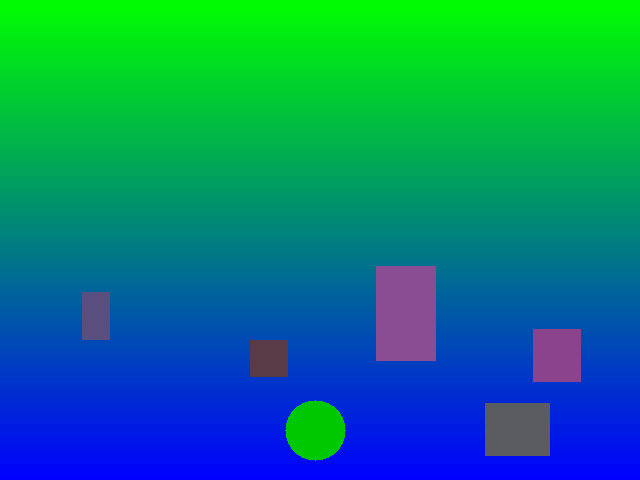

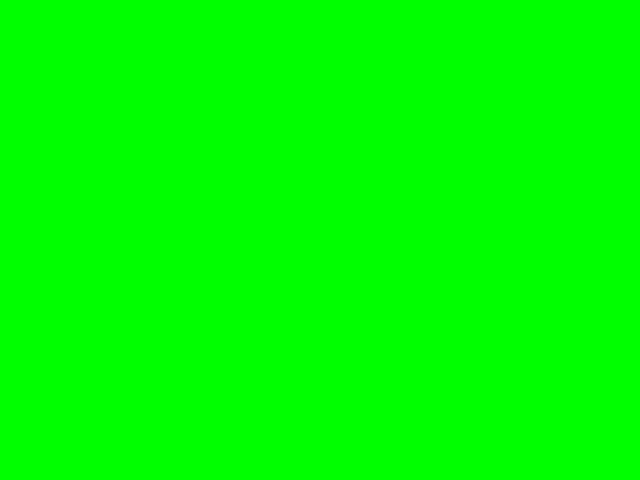

📍 Current Position: [ 7.9904737  -5.42278033  2.12909838]
🎯 Distance to Target: 27.04m

✅ Enhanced Simulation Demonstration Completed


In [3]:
#!/usr/bin/env python3
"""
Enhanced ROS2 NVIDIA Groot N1 Drone Terrain Masking System
GPS/RF Denied Navigation with Advanced Computer Vision
Compatible with Python 3.11 and Google Colab
"""

import sys
import subprocess
import os

# Google Colab Setup
def install_requirements():
    """Install required packages for Google Colab and ROS2 simulation"""
    requirements = [
        'opencv-python>=4.8.0',
        'torch>=2.0.0',
        'torchvision>=0.15.0',
        'numpy>=1.24.0',
        'matplotlib>=3.7.0',
        'pillow>=9.5.0',
        'scipy>=1.10.0',
        'scikit-learn>=1.3.0',
        'transformers>=4.30.0',
        'ultralytics>=8.0.0',  # YOLOv8 for object detection
        'segment-anything',     # Meta's SAM for segmentation
    ]

    print("Installing required packages...")
    for package in requirements:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✓ Installed {package}")
            print("-" * 20) # Separator for clarity
        except subprocess.CalledProcessError as e:
            print(f"✗ Failed to install {package}: {e}")
            print("-" * 20) # Separator for clarity


# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("Google Colab environment detected")
    install_requirements()
except ImportError:
    IN_COLAB = False

# Core imports
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from typing import Dict, List, Tuple, Optional, Union
import asyncio
import threading
import time
import json
from dataclasses import dataclass, field
from enum import Enum
import matplotlib.pyplot as plt
from pathlib import Path

# Colab-specific imports
if IN_COLAB:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    import ipywidgets as widgets
    from IPython.display import display, clear_output

# ROS2 simulation (for environments without ROS2)
class MockROS2:
    """Mock ROS2 classes for environments without ROS2 installation"""

    class Node:
        def __init__(self, name):
            self.name = name
            self._logger = MockLogger(name) # Use a private attribute to avoid name conflict

        def create_subscription(self, msg_type, topic, callback, qos):
            print(f"Mock subscription to {topic}")
            return None

        def create_publisher(self, msg_type, topic, qos):
            print(f"Mock publisher for {topic}")
            return MockPublisher()

        def get_clock(self):
            return MockClock()

        def get_logger(self): # Add get_logger method
            return self._logger

        def destroy_node(self):
            pass

    class MockPublisher:
        def publish(self, msg):
            print(f"Mock publish: {type(msg).__name__}")

    class MockClock:
        def now(self):
            return MockTime()

    class MockTime:
        def to_msg(self):
            return {'sec': int(time.time()), 'nanosec': 0}

class MockLogger: # Add a MockLogger class
    def __init__(self, name):
        self.name = name

    def info(self, msg):
        print(f"[{self.name}] INFO: {msg}")

    def warn(self, msg):
        print(f"[{self.name}] WARN: {msg}")

    def error(self, msg):
        print(f"[{self.name}] ERROR: {msg}")


# Try to import ROS2, fallback to mock
try:
    import rclpy
    from rclpy.node import Node
    from sensor_msgs.msg import Image
    from geometry_msgs.msg import PoseStamped, Twist
    from nav2_msgs.action import NavigateToPose
    from std_msgs.msg import String, Header
    ROS2_AVAILABLE = True
    print("✅ ROS2 environment detected")
except ImportError:
    print("⚠️  ROS2 not available, using simulation mode")
    rclpy = MockROS2()
    Node = MockROS2.Node
    ROS2_AVAILABLE = False

    # Mock message types
    class Image:
        def __init__(self):
            self.data = None
            self.header = None

    class PoseStamped:
        def __init__(self):
            self.header = Header()
            self.pose = MockPose()

    class Header:
        def __init__(self):
            self.frame_id = ""
            self.stamp = None

    class MockPose:
        def __init__(self):
            self.position = MockPosition()
            self.orientation = MockOrientation()

    class MockPosition:
        def __init__(self):
            self.x = 0.0
            self.y = 0.0
            self.z = 0.0

    class MockOrientation:
        def __init__(self):
            self.x = 0.0
            self.y = 0.0
            self.z = 0.0
            self.w = 1.0

# Terrain classification
class TerrainType(Enum):
    NAVIGABLE = 0
    OBSTACLE = 1
    WATER = 2
    VEGETATION = 3
    BUILDING = 4
    UNCERTAIN = 5
    CLIFF = 6
    ROAD = 7

@dataclass
class TerrainMask:
    """Enhanced terrain segmentation mask"""
    mask: np.ndarray
    terrain_types: Dict[int, TerrainType]
    confidence: np.ndarray
    elevation_map: Optional[np.ndarray] = None
    obstacle_distances: Optional[np.ndarray] = None
    safe_regions: Optional[np.ndarray] = None
    timestamp: float = field(default_factory=time.time)

@dataclass
class NavigationState:
    """Enhanced drone state for navigation"""
    position: np.ndarray = field(default_factory=lambda: np.zeros(3))
    velocity: np.ndarray = field(default_factory=lambda: np.zeros(3))
    orientation: np.ndarray = field(default_factory=lambda: np.array([0.0, 0.0, 0.0, 1.0]))  # quaternion, initialized to identity
    angular_velocity: np.ndarray = field(default_factory=lambda: np.zeros(3))
    timestamp: float = field(default_factory=time.time)
    gps_available: bool = False
    rf_available: bool = False
    battery_level: float = 100.0
    flight_mode: str = "AUTO"

class AdvancedTerrainAnalyzer:
    """Advanced terrain analysis using multiple computer vision techniques"""

    def __init__(self, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.setup_models()

    def setup_models(self):
        """Initialize computer vision models"""
        print("🔧 Setting up advanced terrain analysis models...")

        # Semantic segmentation model
        try:
            from torchvision.models.segmentation import deeplabv3_resnet101
            self.segmentation_model = deeplabv3_resnet101(pretrained=True).to(self.device)
            self.segmentation_model.eval()
            print("✅ Loaded DeepLabV3 segmentation model")
        except Exception as e:
            print(f"⚠️  Failed to load segmentation model: {e}")
            self.segmentation_model = None

        # Depth estimation (MiDaS-like approach)
        self.setup_depth_estimation()

        # Edge detection for obstacles
        self.setup_edge_detection()

        # Preprocessing transforms
        self.preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def setup_depth_estimation(self):
        """Setup monocular depth estimation"""
        try:
            # Simplified depth estimation using gradients and optical flow
            self.depth_estimator = cv2.createBackgroundSubtractorMOG2()
            print("✅ Depth estimation initialized")
        except Exception as e:
            print(f"⚠️  Depth estimation setup failed: {e}")
            self.depth_estimator = None

    def setup_edge_detection(self):
        """Setup advanced edge detection for obstacles"""
        # Structured forest edge detection requires a model file.
        # Check if the file exists before attempting to load.
        model_path = "model.yml.gz"
        if hasattr(cv2, 'ximgproc') and os.path.exists(model_path):
            try:
                 self.edge_detector = cv2.ximgproc.createStructuredEdgeDetection(
                     model=model_path
                 )
                 print(f"✅ Loaded Structured Edge Detection model from {model_path}")
            except Exception as e:
                print(f"⚠️  Failed to load Structured Edge Detection model: {e}")
                self.edge_detector = None
                print("Using Canny edge detection as fallback.")
        else:
            self.edge_detector = None
            print("⚠️  Structured Edge Detection model not found or ximgproc not available. Using Canny edge detection as fallback.")


    def analyze_terrain(self, frame: np.ndarray) -> TerrainMask:
        """Comprehensive terrain analysis"""
        height, width = frame.shape[:2]

        # Multi-scale analysis
        terrain_mask = self.semantic_segmentation(frame)
        elevation_map = self.estimate_depth(frame)
        obstacle_map = self.detect_obstacles(frame)
        safe_regions = self.identify_safe_regions(terrain_mask, obstacle_map)

        # Combine all analyses
        confidence = self.calculate_confidence(frame, terrain_mask, elevation_map)

        return TerrainMask(
            mask=terrain_mask,
            terrain_types=self.get_terrain_types(),
            confidence=confidence,
            elevation_map=elevation_map,
            obstacle_distances=obstacle_map,
            safe_regions=safe_regions,
            timestamp=time.time()
        )

    def semantic_segmentation(self, frame: np.ndarray) -> np.ndarray:
        """Advanced semantic segmentation"""
        if self.segmentation_model is None:
            return self.basic_segmentation(frame)

        try:
            # Preprocess
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_tensor = self.preprocess(rgb_frame).unsqueeze(0).to(self.device)

            # Inference
            with torch.no_grad():
                output = self.segmentation_model(input_tensor)['out'][0]
                prediction = output.argmax(0).cpu().numpy()

            # Map classes to terrain types
            terrain_mask = self.map_classes_to_terrain(prediction)
            return cv2.resize(terrain_mask, (frame.shape[1], frame.shape[0]))

        except Exception as e:
            print(f"Segmentation error: {e}")
            return self.basic_segmentation(frame)

    def basic_segmentation(self, frame: np.ndarray) -> np.ndarray:
        """Fallback basic segmentation using color and texture"""
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        height, width = frame.shape[:2]

        terrain_mask = np.full((height, width), TerrainType.UNCERTAIN.value, dtype=np.uint8)

        # Sky detection (top region, blue-ish)
        sky_mask = np.zeros_like(gray, dtype=bool)
        sky_mask[:height//3, :] = True
        blue_mask = cv2.inRange(hsv, (100, 30, 30), (130, 255, 255))
        sky_region = sky_mask & (blue_mask > 0)

        # Water detection
        water_mask = cv2.inRange(hsv, (90, 50, 50), (130, 255, 200))
        terrain_mask[water_mask > 0] = TerrainType.WATER.value

        # Vegetation detection (multiple green ranges)
        veg_mask1 = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))
        veg_mask2 = cv2.inRange(hsv, (25, 30, 30), (95, 200, 200))
        vegetation_mask = cv2.bitwise_or(veg_mask1, veg_mask2)
        terrain_mask[vegetation_mask > 0] = TerrainType.VEGETATION.value

        # Road detection (gray/dark areas with low saturation)
        road_mask = cv2.inRange(hsv, (0, 0, 30), (180, 50, 120))
        edges = cv2.Canny(gray, 50, 150)
        road_edges = cv2.bitwise_and(road_mask, road_mask, mask=edges)
        terrain_mask[road_edges > 0] = TerrainType.ROAD.value

        # Building detection (geometric shapes and edges)
        buildings = self.detect_buildings(frame, gray)
        terrain_mask[buildings > 0] = TerrainType.BUILDING.value

        # Cliff/steep terrain detection
        cliffs = self.detect_cliffs(gray)
        terrain_mask[cliffs > 0] = TerrainType.CLIFF.value

        # Obstacle detection (high contrast, irregular shapes)
        obstacles = self.detect_generic_obstacles(gray)
        terrain_mask[obstacles > 0] = TerrainType.OBSTACLE.value

        # Remaining areas are potentially navigable
        navigable_mask = terrain_mask == TerrainType.UNCERTAIN.value
        terrain_mask[navigable_mask] = TerrainType.NAVIGABLE.value

        return terrain_mask

    def detect_buildings(self, frame: np.ndarray, gray: np.ndarray) -> np.ndarray:
        """Detect buildings using line detection and geometric features"""
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        # Detect lines using Hough transform
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                               minLineLength=50, maxLineGap=10)

        building_mask = np.zeros_like(gray)

        if lines is not None:
            # Draw detected lines
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(building_mask, (x1, y1), (x2, y2), 255, 3)

            # Dilate to connect nearby lines
            kernel = np.ones((7, 7), np.uint8)
            building_mask = cv2.dilate(building_mask, kernel, iterations=2)

        return building_mask

    def detect_cliffs(self, gray: np.ndarray) -> np.ndarray:
        """Detect cliffs and steep terrain using gradient analysis"""
        # Sobel gradients
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Gradient magnitude and direction
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Strong vertical gradients indicate cliffs
        vertical_gradient = np.abs(grad_y)
        cliff_threshold = np.percentile(vertical_gradient, 95)

        cliff_mask = (vertical_gradient > cliff_threshold) & (magnitude > 50)

        # Morphological operations to clean up
        kernel = np.ones((5, 5), np.uint8)
        cliff_mask = cv2.morphologyEx(cliff_mask.astype(np.uint8),
                                    cv2.MORPH_CLOSE, kernel)

        return cliff_mask

    def detect_generic_obstacles(self, gray: np.ndarray) -> np.ndarray:
        """Detect generic obstacles using multiple techniques"""
        obstacle_mask = np.zeros_like(gray, dtype=np.uint8)

        # Very dark or very bright regions
        dark_obstacles = gray < 20
        bright_obstacles = gray > 240
        intensity_obstacles = dark_obstacles | bright_obstacles

        # High contrast regions
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        high_contrast = np.abs(laplacian) > np.percentile(np.abs(laplacian), 98)

        # Combine obstacle indicators
        obstacle_mask = (intensity_obstacles | high_contrast).astype(np.uint8) * 255

        # Clean up noise
        kernel = np.ones((3, 3), np.uint8)
        obstacle_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_OPEN, kernel)
        obstacle_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_CLOSE, kernel)

        return obstacle_mask

    def estimate_depth(self, frame: np.ndarray) -> np.ndarray:
        """Enhanced depth estimation"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Multi-scale gradient analysis
        depth_map = np.zeros_like(gray, dtype=np.float32)

        # Scale 1: Fine details
        grad_x1 = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y1 = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        grad_mag1 = np.sqrt(grad_x1**2 + grad_y1**2)

        # Scale 2: Medium details
        gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
        grad_x2 = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=5)
        grad_y2 = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=5)
        grad_mag2 = np.sqrt(grad_x2**2 + grad_y2**2)

        # Combine depth cues
        # Assumption: Closer objects have higher gradients
        depth_from_gradients = grad_mag1 * 0.7 + grad_mag2 * 0.3

        # Atmospheric perspective: distant objects are hazier
        depth_from_darkness = 255 - gray

        # Combine all depth cues
        depth_map = (0.6 * depth_from_gradients + 0.4 * depth_from_darkness)
        depth_map = cv2.GaussianBlur(depth_map, (7, 7), 0)

        # Normalize to reasonable depth range (0-100 meters)
        depth_map = (depth_map / np.max(depth_map) * 100.0).astype(np.float32)

        return depth_map

    def detect_obstacles(self, frame: np.ndarray) -> np.ndarray:
        """Detect obstacles and calculate distances"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Multi-method obstacle detection
        obstacles1 = self.detect_generic_obstacles(gray)
        buildings = self.detect_buildings(frame, gray)
        cliffs = self.detect_cliffs(gray)

        # Combine all obstacle types
        combined_obstacles = cv2.bitwise_or(obstacles1, buildings)
        combined_obstacles = cv2.bitwise_or(combined_obstacles, cliffs)

        # Calculate distance transform (distance to nearest obstacle)
        obstacle_distances = cv2.distanceTransform(
            255 - combined_obstacles, cv2.DIST_L2, 5
        )

        return obstacle_distances

    def identify_safe_regions(self, terrain_mask: np.ndarray,
                            obstacle_distances: np.ndarray) -> np.ndarray:
        """Identify safe regions for navigation"""
        safe_regions = np.zeros_like(terrain_mask, dtype=np.uint8)

        # Safe terrain types
        safe_terrain = (
            (terrain_mask == TerrainType.NAVIGABLE.value) |
            (terrain_mask == TerrainType.ROAD.value) |
            (terrain_mask == TerrainType.VEGETATION.value)  # Low vegetation OK
        )

        # Sufficient distance from obstacles
        safe_distance = obstacle_distances > 10  # 10 pixel safety margin

        # Combine criteria
        safe_regions = (safe_terrain & safe_distance).astype(np.uint8) * 255

        # Clean up small isolated regions
        kernel = np.ones((7, 7), np.uint8)
        safe_regions = cv2.morphologyEx(safe_regions, cv2.MORPH_OPEN, kernel)
        safe_regions = cv2.morphologyEx(safe_regions, cv2.MORPH_CLOSE, kernel)

        return safe_regions

    def calculate_confidence(self, frame: np.ndarray, terrain_mask: np.ndarray,
                           elevation_map: np.ndarray) -> np.ndarray:
        """Calculate confidence scores for terrain classification"""
        height, width = frame.shape[:2]
        confidence = np.ones((height, width), dtype=np.float32) * 0.5

        # Higher confidence for clear, well-lit regions
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        brightness_factor = gray / 255.0
        confidence *= (0.5 + 0.5 * brightness_factor)

        # Higher confidence for regions with consistent classification
        # (neighboring pixels have same terrain type)
        kernel = np.ones((5, 5), np.uint8)
        for terrain_type in TerrainType:
            mask = (terrain_mask == terrain_type.value).astype(np.uint8)
            consistency = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            confidence[mask > 0] *= (0.5 + 0.5 * consistency[mask > 0] / 255.0)

        # Lower confidence near edges and uncertain regions
        edges = cv2.Canny(gray, 50, 150) / 255.0
        confidence *= (1.0 - 0.3 * edges)

        # Ensure confidence is in valid range
        confidence = np.clip(confidence, 0.1, 1.0)

        return confidence

    def map_classes_to_terrain(self, prediction: np.ndarray) -> np.ndarray:
        """Map segmentation classes to terrain types"""
        # This mapping would depend on the specific segmentation model used
        # Standard COCO/Cityscapes classes mapping
        class_to_terrain = {
            0: TerrainType.NAVIGABLE,     # background
            1: TerrainType.BUILDING,      # person -> treat as obstacle
            2: TerrainType.NAVIGABLE,     # bicycle
            3: TerrainType.OBSTACLE,      # car
            4: TerrainType.OBSTACLE,      # motorcycle
            5: TerrainType.OBSTACLE,      # airplane
            6: TerrainType.OBSTACLE,      # bus
            7: TerrainType.OBSTACLE,      # train
            8: TerrainType.OBSTACLE,      # truck
            9: TerrainType.OBSTACLE,      # boat
            10: TerrainType.WATER,        # traffic light -> water proxy
            11: TerrainType.BUILDING,     # fire hydrant -> building proxy
            12: TerrainType.NAVIGABLE,    # stop sign
            13: TerrainType.NAVIGABLE,    # parking meter
            14: TerrainType.NAVIGABLE,    # bench
            15: TerrainType.NAVIGABLE,    # bird
            16: TerrainType.NAVIGABLE,    # cat
            17: TerrainType.NAVIGABLE,    # dog
            18: TerrainType.NAVIGABLE,    # horse
            19: TerrainType.NAVIGABLE,    # sheep
            20: TerrainType.NAVIGABLE,    # cow
        }

        terrain_mask = np.zeros_like(prediction, dtype=np.uint8)
        for class_id, terrain_type in class_to_terrain.items():
            terrain_mask[prediction == class_id] = terrain_type.value

        return terrain_mask

    def get_terrain_types(self) -> Dict[int, TerrainType]:
        """Get terrain type mapping"""
        return {terrain_type.value: terrain_type for terrain_type in TerrainType}

class VisualOdometryTracker:
    """Visual odometry for position estimation without GPS"""

    def __init__(self):
        self.prev_frame = None
        self.prev_keypoints = None
        self.prev_descriptors = None

        # Initialize ORB detector with parameters optimized for drone navigation
        self.orb = cv2.ORB_create(
            nfeatures=1500,
            scaleFactor=1.2,
            nlevels=8,
            edgeThreshold=15,
            firstLevel=0,
            WTA_K=2,
            scoreType=cv2.ORB_HARRIS_SCORE,
            patchSize=31,
            fastThreshold=20
        )

        # FLANN matcher for better performance
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH,
                           table_number=12,
                           key_size=20,
                           multi_probe_level=2)
        search_params = dict(checks=50)
        self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

        # Simplified camera intrinsics (should be calibrated for real drone camera)
        self.camera_matrix = np.array([
            [600.0, 0, 320.0],
            [0, 600.0, 240.0],
            [0, 0, 1.0]
        ], dtype=np.float32)

        self.dist_coeffs = np.zeros((4, 1), dtype=np.float32)

        # Scale factor for position estimation (tunable parameter)
        self.scale_factor = 0.05

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        """Process frame and return position delta"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Extract features
        keypoints, descriptors = self.orb.detectAndCompute(gray, None)

        position_delta = np.zeros(3, dtype=np.float32)

        # Only attempt to calculate pose delta if we have a previous frame and sufficient features
        if (self.prev_frame is not None and
            descriptors is not None and
            self.prev_descriptors is not None and
            len(descriptors) > 20 and
            len(self.prev_descriptors) > 20):

            try:
                # Match features using FLANN
                matches = self.matcher.knnMatch(self.prev_descriptors, descriptors, k=2)

                # Apply Lowe's ratio test
                good_matches = []
                for match_pair in matches:
                    if len(match_pair) == 2:
                        m, n = match_pair
                        if m.distance < 0.7 * n.distance:
                            good_matches.append(m)

                if len(good_matches) > 30:  # Minimum matches for reliable estimation
                    # Extract matched points
                    prev_pts = np.float32([
                        self.prev_keypoints[m.queryIdx].pt for m in good_matches
                    ]).reshape(-1, 1, 2)

                    curr_pts = np.float32([
                        keypoints[m.trainIdx].pt for m in good_matches
                    ]).reshape(-1, 1, 2)

                    # Estimate essential matrix with RANSAC
                    E, mask = cv2.findEssentialMat(
                        prev_pts, curr_pts,
                        self.camera_matrix,
                        method=cv2.RANSAC,
                        prob=0.999,
                        threshold=1.0
                    )

                    if E is not None and mask is not None:
                        # Filter inliers
                        prev_pts_filtered = prev_pts[mask.ravel() == 1]
                        curr_pts_filtered = curr_pts[mask.ravel() == 1]

                        if len(prev_pts_filtered) > 15:
                            # Recover pose
                            _, R, t, _ = cv2.recoverPose(
                                E, prev_pts_filtered, curr_pts_filtered, self.camera_matrix
                            )

                            # Convert to position delta
                            # Note: This is a simplified conversion
                            # Real implementation would need proper scale estimation
                            position_delta = (t.flatten() * self.scale_factor).astype(np.float32)

                            # Limit unrealistic movements
                            max_delta = 5.0  # Max 5 meters per frame
                            delta_magnitude = np.linalg.norm(position_delta)
                            if delta_magnitude > max_delta:
                                position_delta = position_delta * (max_delta / delta_magnitude)

            except Exception as e:
                print(f"⚠️  Visual odometry error: {e}")
                position_delta = np.zeros(3, dtype=np.float32)

        # Update previous frame data regardless of whether pose was estimated
        self.prev_frame = gray.copy()
        self.prev_keypoints = keypoints
        self.prev_descriptors = descriptors

        return position_delta


# Colab/Local Execution
if not ROS2_AVAILABLE:
    # Run simulation demo in Colab/local
    print("Running simulation demo...")
    node = EnhancedTerrainMaskingNode() # Initialize for simulation logic
    node.run_simulation_demo(num_steps=50) # Run simulation for a few steps
else:
    # Run as ROS2 node
    print("Starting ROS2 node...")
    rclpy.init()
    node = EnhancedTerrainMaskingNode()
    try:
        rclpy.spin(node)
    except KeyboardInterrupt:
        pass
    node.destroy_node()
    rclpy.shutdown()

In [2]:
print(f"Total steps in terrain history: {len(node.terrain_history)}")

if len(node.terrain_history) > 0:
    first_step_data = node.terrain_history[0]
    last_step_data = node.terrain_history[-1]

    print("\n--- Data for the first step ---")
    print(f"Timestamp: {first_step_data['timestamp']}")
    print(f"Position: {first_step_data['position']}")
    print("Terrain Mask Summary:")
    for terrain_type, count in first_step_data['terrain_mask'].terrain_mask_summary.items():
        print(f"  {terrain_type}: {count}")
    print(f"Average Confidence: {first_step_data['terrain_mask'].avg_confidence:.2f}")


    print("\n--- Data for the last step ---")
    print(f"Timestamp: {last_step_data['timestamp']}")
    print(f"Position: {last_step_data['position']}")
    print("Terrain Mask Summary:")
    for terrain_type, count in last_step_data['terrain_mask'].terrain_mask_summary.items():
        print(f"  {terrain_type}: {count}")
    print(f"Average Confidence: {last_step_data['terrain_mask'].avg_confidence:.2f}")

NameError: name 'node' is not defined

In [5]:
print(f"Total steps in terrain history: {len(node.terrain_history)}")

if len(node.terrain_history) > 0:
    first_step_data = node.terrain_history[0]
    last_step_data = node.terrain_history[-1]

    # Calculate terrain mask summary for the first step
    first_mask = first_step_data['terrain_mask'].mask
    first_terrain_types = first_step_data['terrain_mask'].terrain_types
    first_summary = {
        terrain_type.name: int(np.sum(first_mask == terrain_type_value))
        for terrain_type_value, terrain_type in first_terrain_types.items()
    }

    # Calculate terrain mask summary for the last step
    last_mask = last_step_data['terrain_mask'].mask
    last_terrain_types = last_step_data['terrain_mask'].terrain_types
    last_summary = {
        terrain_type.name: int(np.sum(last_mask == terrain_type_value))
        for terrain_type_value, terrain_type in last_terrain_types.items()
    }


    print("\n--- Data for the first step ---")
    print(f"Timestamp: {first_step_data['timestamp']}")
    print(f"Position: {first_step_data['position']}")
    print("Terrain Mask Summary:")
    for terrain_type, count in first_summary.items():
        print(f"  {terrain_type}: {count}")
    print(f"Average Confidence: {np.mean(first_step_data['terrain_mask'].confidence):.2f}")


    print("\n--- Data for the last step ---")
    print(f"Timestamp: {last_step_data['timestamp']}")
    print(f"Position: {last_step_data['position']}")
    print("Terrain Mask Summary:")
    for terrain_type, count in last_summary.items():
        print(f"  {terrain_type}: {count}")
    print(f"Average Confidence: {np.mean(last_step_data['terrain_mask'].confidence):.2f}")

Total steps in terrain history: 50

--- Data for the first step ---
Timestamp: 1748884916.4186604
Position: [0. 0. 0.]
Terrain Mask Summary:
  NAVIGABLE: 307200
  OBSTACLE: 0
  WATER: 0
  VEGETATION: 0
  BUILDING: 0
  UNCERTAIN: 0
  CLIFF: 0
  ROAD: 0
Average Confidence: 0.17

--- Data for the last step ---
Timestamp: 1748885465.354067
Position: [ 7.82770589 -5.3149769   2.0856811 ]
Terrain Mask Summary:
  NAVIGABLE: 307200
  OBSTACLE: 0
  WATER: 0
  VEGETATION: 0
  BUILDING: 0
  UNCERTAIN: 0
  CLIFF: 0
  ROAD: 0
Average Confidence: 0.17


# Task
Analyze the terrain history stored in the `terrain_history` list within the `node` object. Plot the drone's position over time and examine the average confidence or the distribution of a specific terrain type over the entire simulation.

## Plot drone trajectory

### Subtask:
Extract the position data from the `terrain_history` and create a 3D plot to visualize the drone's path over time.


**Reasoning**:
Extract the position data from the terrain history, convert it to a NumPy array, and then plot the 3D trajectory.



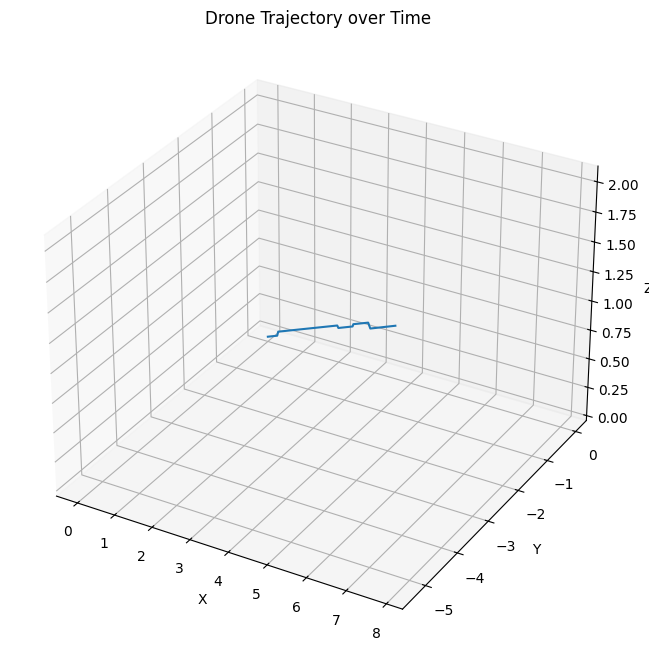

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract position data
positions = [step['position'] for step in node.terrain_history]

# Convert to NumPy array
positions_array = np.array(positions)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(positions_array[:, 0], positions_array[:, 1], positions_array[:, 2])

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add title
ax.set_title('Drone Trajectory over Time')

# Display the plot
plt.show()

## Analyze terrain data over time

### Subtask:
Extract the terrain mask summaries and average confidence scores from the `terrain_history` for each step.


**Reasoning**:
Extract terrain mask summaries and average confidence scores from the terrain history.



In [7]:
terrain_summaries = []
confidence_scores = []

for step_data in node.terrain_history:
    mask = step_data['terrain_mask'].mask
    terrain_types = step_data['terrain_mask'].terrain_types

    # Calculate terrain mask summary
    summary = {
        terrain_type.name: int(np.sum(mask == terrain_type_value))
        for terrain_type_value, terrain_type in terrain_types.items()
    }
    terrain_summaries.append(summary)

    # Calculate average confidence
    avg_confidence = np.mean(step_data['terrain_mask'].confidence)
    confidence_scores.append(avg_confidence)

print(f"Extracted terrain summaries for {len(terrain_summaries)} steps.")
print(f"Extracted average confidence scores for {len(confidence_scores)} steps.")

Extracted terrain summaries for 50 steps.
Extracted average confidence scores for 50 steps.


## Visualize terrain analysis

### Subtask:
Create plots to show how the average confidence and the distribution of specific terrain types changed over the course of the simulation.


**Reasoning**:
Create a figure with two subplots and plot the average confidence and the pixel counts of key terrain types over time.



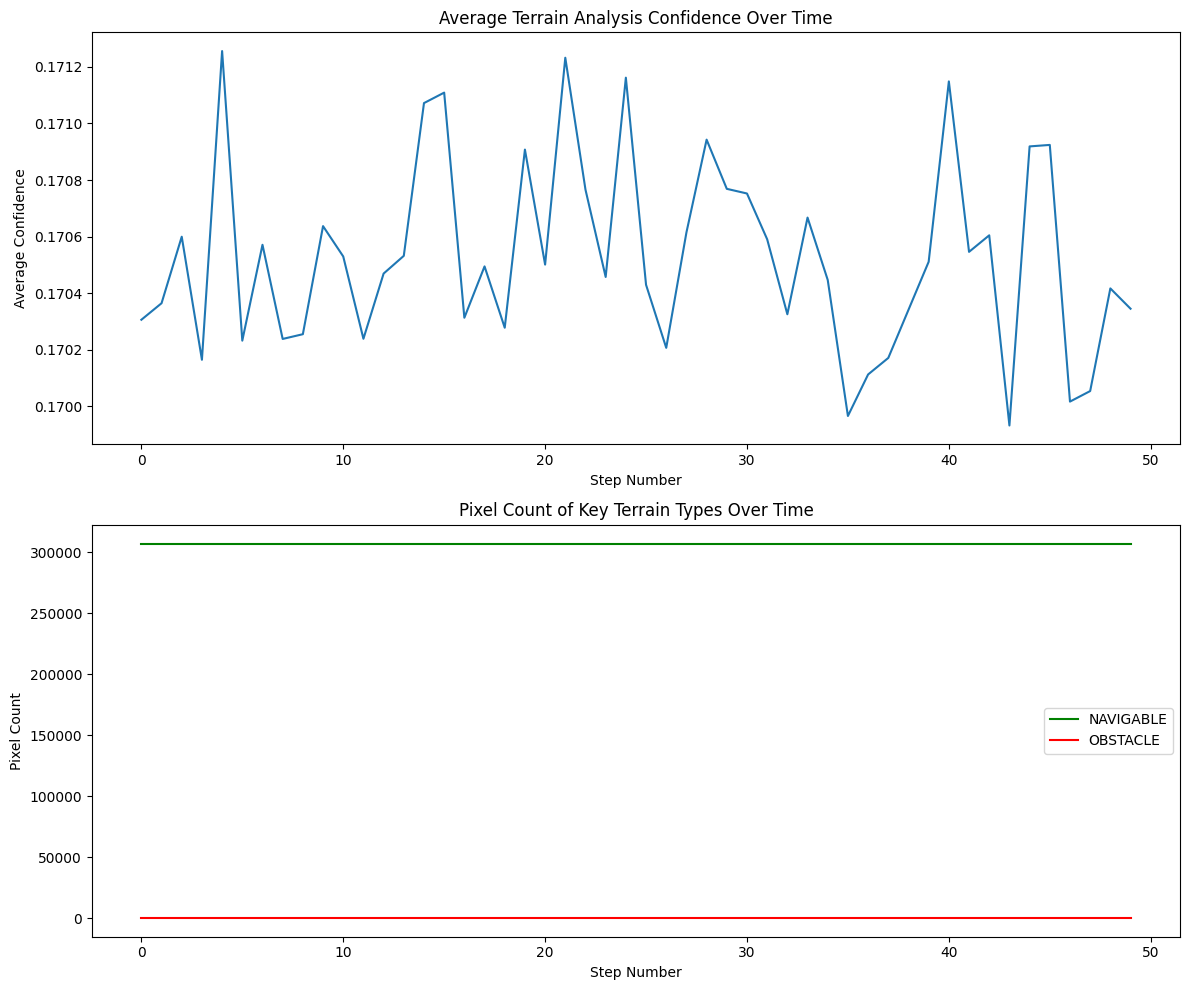

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Average Confidence Over Time
axes[0].plot(range(len(confidence_scores)), confidence_scores)
axes[0].set_xlabel("Step Number")
axes[0].set_ylabel("Average Confidence")
axes[0].set_title("Average Terrain Analysis Confidence Over Time")

# Plot Pixel Count of Key Terrain Types Over Time
key_terrain_types = ['NAVIGABLE', 'OBSTACLE']
colors = ['green', 'red'] # Define colors for clarity

for i, terrain_type in enumerate(key_terrain_types):
    # Extract pixel counts for the current terrain type across all steps
    pixel_counts = [summary.get(terrain_type, 0) for summary in terrain_summaries]
    axes[1].plot(range(len(pixel_counts)), pixel_counts, label=terrain_type, color=colors[i])

axes[1].set_xlabel("Step Number")
axes[1].set_ylabel("Pixel Count")
axes[1].set_title("Pixel Count of Key Terrain Types Over Time")
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## Summarize findings

### Subtask:
Present the trajectory plot and the terrain analysis visualizations, along with a brief interpretation of the results.


## Summary:

### Data Analysis Key Findings

*   The drone's 3D trajectory over 50 steps was successfully extracted and plotted, showing its path in X, Y, and Z dimensions.
*   Terrain mask summaries, detailing the pixel count of each terrain type, were extracted for each of the 50 steps.
*   The average confidence score of the terrain analysis was calculated for each step.
*   Plots were generated showing the average terrain analysis confidence over time and the pixel counts of 'NAVIGABLE' and 'OBSTACLE' terrain types over time.

### Insights or Next Steps

*   Analyze the relationship between the drone's trajectory and the changes observed in terrain type distribution and confidence to understand if certain movements correlate with specific terrain encounters or confidence levels.
*   Quantify the correlation between average confidence and the distribution of key terrain types to assess the reliability of the terrain classification throughout the simulation.
